In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
def read_metrics(log_dir, metric_name: str, interval: int = 1):
    epochs = None
    results = []
    for seed_dir in os.listdir(log_dir):
        seed_results = {}
        ckpt_path = os.path.join(log_dir, seed_dir, "results")
        if not os.path.exists(ckpt_path):
            continue
        for result_file in os.listdir(ckpt_path):
            if not result_file.endswith(".csv"):
                continue
            epoch = int(result_file.split("_")[1])
            if epoch % interval != 0:
                continue
            seed_results[epoch] = pd.read_csv(os.path.join(ckpt_path, result_file))[
                metric_name
            ][0]

        results.append(seed_results)
        if epochs is None:
            epochs = list(seed_results.keys())
        else:
            epochs = list(set(epochs).intersection(seed_results.keys()))

    epochs = sorted(epochs)
    for i, seed_result in enumerate(results):
        results[i] = [seed_result[epoch] for epoch in epochs]

    return np.array(epochs), np.array(results)

In [40]:
colors = [
    "#4C72B0", "#C44E52", "#1ba784",
]

In [41]:
dataset_logs = {
    "CarRun": {
        "CDiff": "../logs/diffuser_inv_dsrl/OfflineCarRun-v0/h_12-tgt_575.0,10.0-usecost_True",
        "Diffuser": "../logs/diffuser_inv_dsrl/OfflineCarRun-v0/h_12-tgt_575.0,10.0-usecost_False",
        "CDiff-Non-Negative": "../logs/diffuser_inv_dsrl_noneg/OfflineCarRun-v0/h_12-tgt_575.0,10.0-usecost_True",
    },
    "BallRun": {
        "CDiff": "../logs/diffuser_inv_dsrl/OfflineBallRun-v0/h_12-tgt_500.0,10.0-usecost_True",
        "Diffuser": "../logs/diffuser_inv_dsrl/OfflineBallRun-v0/h_12-tgt_500.0,10.0-usecost_False",
    },
    "DroneCircle": {
        "CDiff": "../logs/diffuser_inv_dsrl/OfflineDroneCircle-v0/h_12-tgt_700.0,10.0-usecost_True-guidew_1.2",
        "Diffuser": "../logs/diffuser_inv_dsrl/OfflineDroneCircle-v0/h_12-tgt_700.0,10.0-usecost_False",
    },
}

(0.7, 1.1)

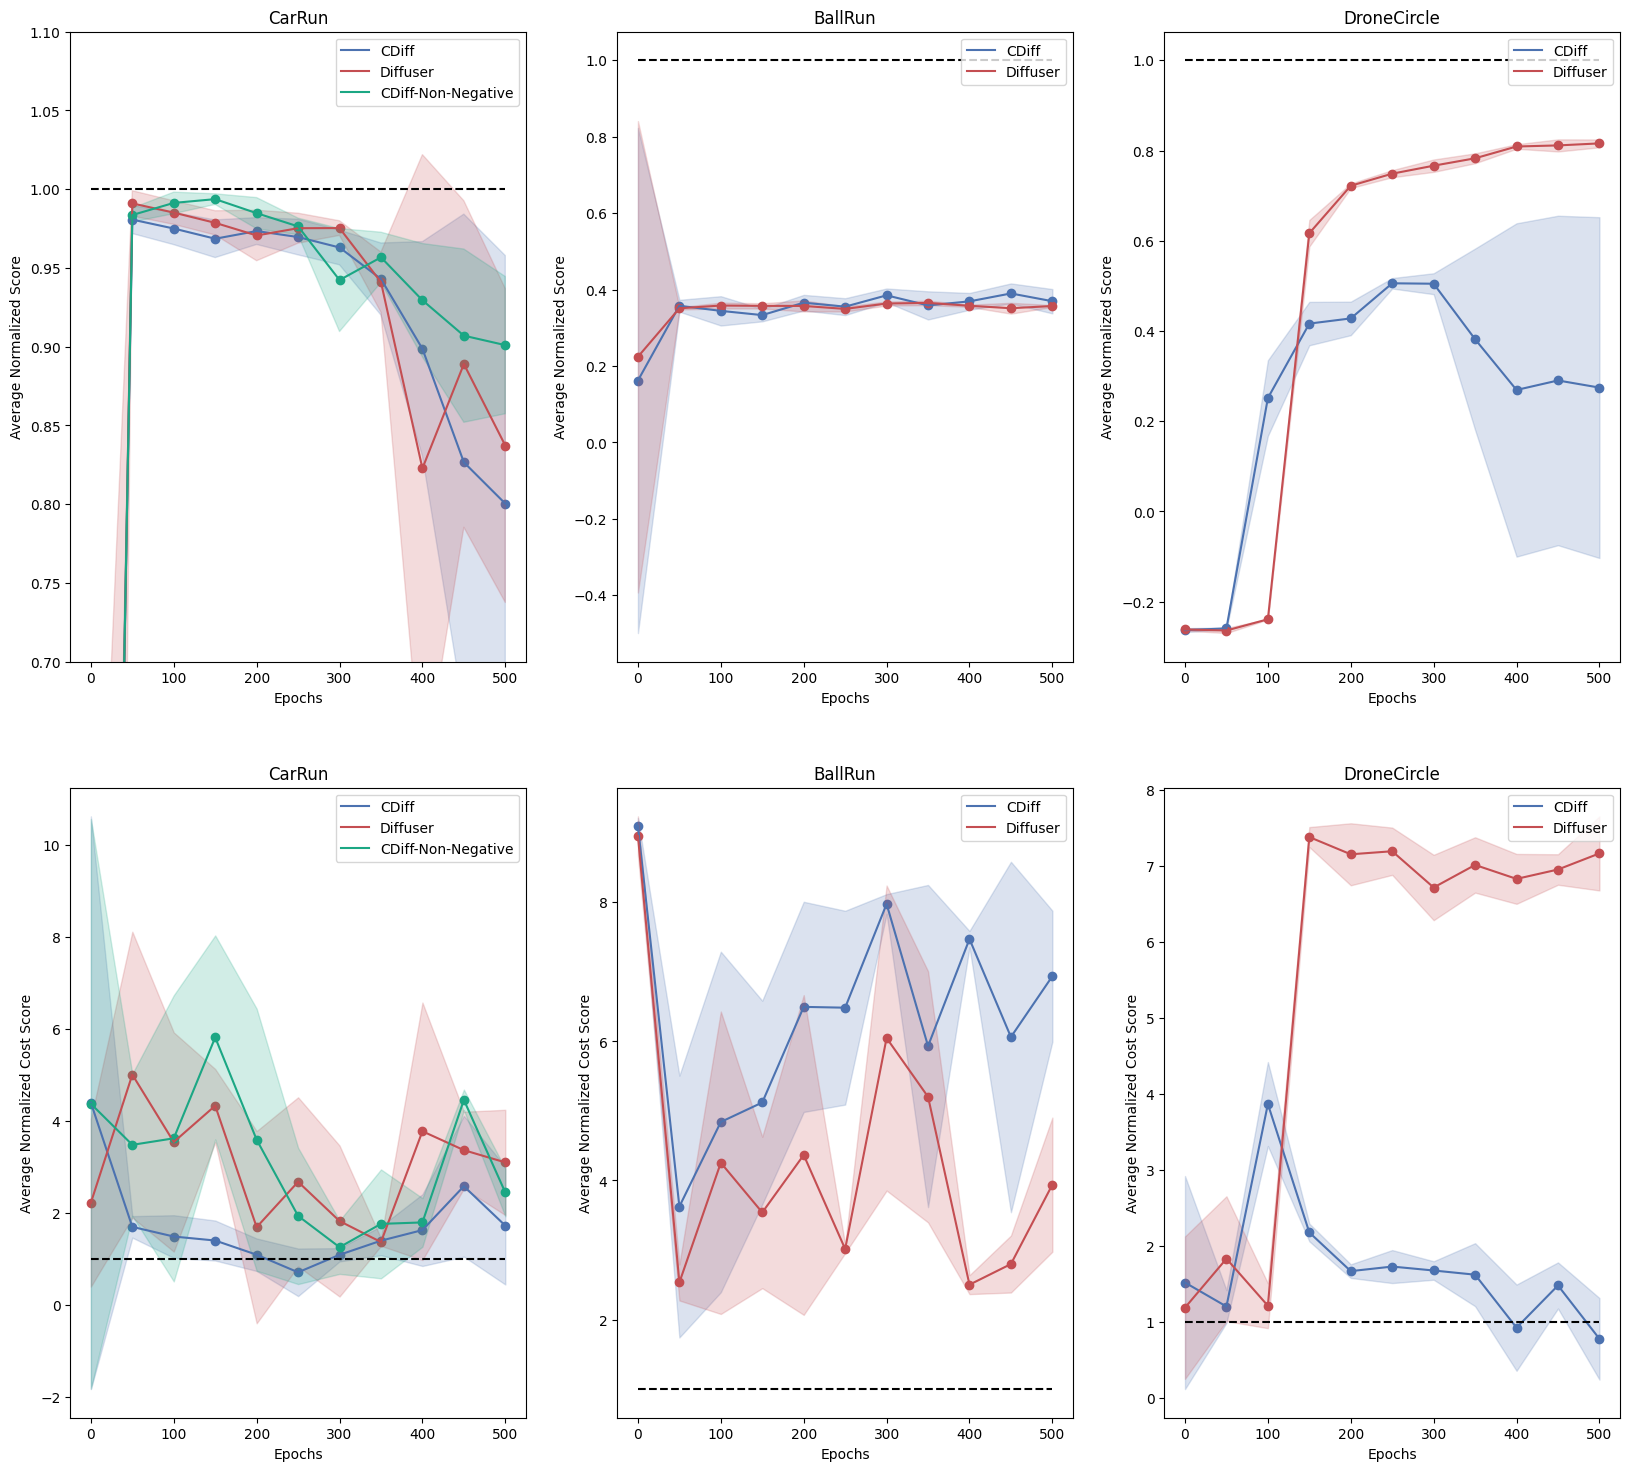

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(20, 18))

for idx, (dataset, logs) in enumerate(dataset_logs.items()):
    for m_idx, (method, log_dir) in enumerate(logs.items()):
        epochs, returns = read_metrics(log_dir, "average_normalized_return", interval=50)
        axes[0][idx].scatter(epochs, returns.mean(axis=0), color=colors[m_idx])
        axes[0][idx].plot(
            epochs, returns.mean(axis=0), label=method, color=colors[m_idx]
        )
        axes[0][idx].fill_between(
            epochs,
            returns.mean(axis=0) - returns.std(axis=0),
            returns.mean(axis=0) + returns.std(axis=0),
            alpha=0.2,
            color=colors[m_idx],
        )

        epochs, cost_returns = read_metrics(log_dir, "average_normalized_cost_return", interval=50)

        axes[1][idx].scatter(epochs, cost_returns.mean(axis=0), color=colors[m_idx])
        axes[1][idx].plot(
            epochs, cost_returns.mean(axis=0), label=method, color=colors[m_idx]
        )
        axes[1][idx].fill_between(
            epochs,
            cost_returns.mean(axis=0) - cost_returns.std(axis=0),
            cost_returns.mean(axis=0) + cost_returns.std(axis=0),
            alpha=0.2,
            color=colors[m_idx],
        )

    axes[0][idx].set_xlabel("Epochs")
    axes[0][idx].set_ylabel("Average Normalized Score")
    axes[0][idx].set_title(dataset)
    axes[0][idx].legend()
    axes[0][idx].hlines(1.0, 0, 500, linestyles="dashed", colors="k")

    axes[1][idx].set_xlabel("Epochs")
    axes[1][idx].set_ylabel("Average Normalized Cost Score")
    axes[1][idx].set_title(dataset)
    axes[1][idx].legend()
    axes[1][idx].hlines(1.0, 0, 500, linestyles="dashed", colors="k")

axes[0][0].set_ylim([0.7, 1.1])

# fig.savefig("save_figs/d4rl_results.png")